In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

**Complex Reactions with Heat Effects in a PFR**

You can download Fogler's book from here: https://doku.pub/download/h-scott-fogler-essentials-of-chemical-reaction-engineering-z0x2ze484wqn

In [2]:
# molar rates  
Fa0 = 5 # mol/min
Fb0 = 2*Fa0 # mol/min since the feed is stoichiometric (A+2B->C) and FA0 is 5 mol/min
Fc0 = 0 # mol/min
Fd0 = 0 # mol/min
Fi0 = np.array([Fa0, Fb0, Fc0, Fd0])

# initial concentration
Ct0 = 0.2 # mol/dm3

# entering pressure
P = 100 # atm
yp = 1  # no pressure drop

# reaction enthalpies
dHr1B = -15000 # cal/mol B
dHr2A = -10000 # cal/mol A
T0 = 300
    
Ea1 = 8000 # cal/mol
K1a0 = 40
Ea2 = 12000 # cal/mol
k2a0 = 2
R = 1.987 # cal/mol/K

Cpa = 10 # cal/mol/K
Cpb = 12 # cal/mol/K
Cpc = 14 # cal/mol/K
Cpd = 16 # cal/mol/K
Cpi = np.array([10, 12, 14, 16]) # cal/mol/K

Ua = 80 # cal/min/K
Ta0 = 325 # K
m = 50 # mol/min
Cp_cool = 10 # cal/mol/K is the heat capacity of th coolant fluid

V = 10 # dm3

Text(0.5, 1.0, 'Co-current heat exchange')

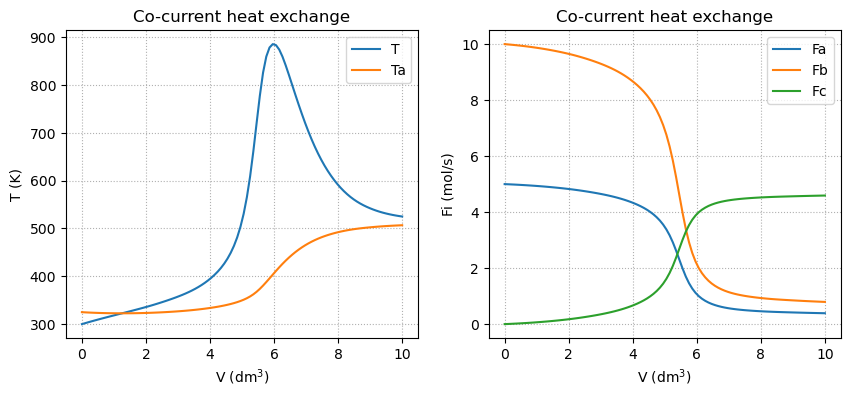

In [3]:
a, b, c, d = np.arange(4)

def arr(k1, Ea, T):
    
    return k1*np.exp((Ea/R)*(1/300-1/T))

def odes(x, y, *params):
    
    Ct0, T0, yp, K1a0, Ea1, k2a0, Ea2, dHr1B, dHr2A, Ua, Cpi, m, Cp_cool = params 
    
    F = y[:-2]
    T = y[-2]
    Ta = y[-1]
    
    C = Ct0*(F/F.sum())*(T0/T)*yp
    
    k1a = arr(K1a0, Ea1, T)
    k2c = arr(k2a0, Ea2, T)
    
    # elementary rate laws
    r1a = -k1a*C[a]*C[b]**2
    r2c = -k2c*C[a]**2*C[c]**3
    
    # relative rates based on stoichiometry of the reaction A+2B->C & 2A+3C->D
    r1b = 2*r1a
    r1c = -r1a
    r2a = (2/3)*r2c
    r2d = -(1/3)*r2c
    
    # net rates - always the sum of relative rates
    ra = r1a + r2a
    rb = r1b
    rc = r1c + r2c
    rd = r2d

    # mass balance
    rates = np.array([ra, rb, rc, rd])
    dF = rates
    
    # energy balance T
    Qg = r1b*dHr1B + r2a*dHr2A # "Heat Generated" term
    Qr = Ua*(T-Ta) # "Heat Removed" term
    sumFiCpi = (F*Cpi).sum()
    dT = (Qg-Qr)/sumFiCpi
    
    # energy balance Ta
    dTa = Ua*(T-Ta)/m/Cp_cool
    
    return np.hstack((dF, dT, dTa))
       
y0 = np.hstack((Fi0, T0, Ta0))

sol = solve_ivp(odes, (0, V), y0, t_eval = np.linspace(0, V, 100),
               args = (Ct0, T0, yp, K1a0, Ea1, k2a0, Ea2, dHr1B, dHr2A, Ua, Cpi, m, Cp_cool))

fig, ax = plt.subplots(ncols = 2, figsize = (10, 4), dpi = 100)


ax[0].set_ylabel("T (K)")
ax[0].set_xlabel("V (dm$^3$)")
ax[0].plot(sol.t, sol.y[4])
ax[0].plot(sol.t, sol.y[5])
ax[0].legend(['T', 'Ta'])
ax[0].grid(linestyle= ':')
ax[0].set_title('Co-current heat exchange')

for yi in sol.y[:-3]:
    ax[1].plot(sol.t, yi)

ax[1].set_ylabel("Fi (mol/s)")
ax[1].set_xlabel("V (dm$^3$)")
ax[1].legend(['Fa', 'Fb', 'Fc'])
ax[1].grid(linestyle= ':')
ax[1].set_title('Co-current heat exchange')

### Optimization

$Variables: V, T(0), T_a(0)$

$Objective: F_C(V) - F_C(0)$

$Functional~constraint: T(W) \leq 495 $

$Variable~bounds: 0.1 \leq V \leq 10,~250 \leq T(0) \leq 800,  ~200 \leq T_a(0) \leq 800$

In [4]:
def obj_conv(x):
    
    V = x[0]
    T0 = x[1]
    Ta0 = x[2]
    
    y0 = np.hstack((Fi0, T0, Ta0))
    
    sol = solve_ivp(odes, (0, V), y0,
                   args = (Ct0, T0, yp, K1a0, Ea1, k2a0, Ea2, dHr1B, dHr2A, Ua, Cpi, m, Cp_cool))
    
    y = sol.y[:, -1]
    F = y[:-2] # while T = y[-2] and Ta = y[-1]
    
    Fa = (F[0] - Fi0[0])
    Fb = (F[1] - Fi0[1])
    Fc = (F[2] - Fi0[2])
    Fd = (F[3] - Fi0[3])
     
    return  -Fc


def cons_func(x):
    
    V = x[0]
    T0 = x[1]
    Ta0 = x[2]
    
    y0 = np.hstack((Fi0, T0, Ta0))
    
    sol = solve_ivp(odes, (0, V), y0,
                   args = (Ct0, T0, yp, K1a0, Ea1, k2a0, Ea2, dHr1B, dHr2A, Ua, Cpi, m, Cp_cool))
    
    y = sol.y[:, -1]
    T = y[-2]
    
    return  495 - T

bounds = [(0.001, 10), (250, 800), (200, 800)]

sol_constrained = minimize(obj_conv, np.array([5, 300, 300]), method="SLSQP", bounds=bounds,
                           constraints={"fun":cons_func, "type":"ineq"})

In [5]:
sol_constrained.x

array([  5.06923352, 396.3651757 , 231.27035195])

In [6]:
def ode_from_opt(x, t_eval=None):
    
    V = x[0]
    T0 = x[1]
    Ta0 = x[2]
    
    y0 = np.hstack((Fi0, T0, Ta0))
    
    sol = solve_ivp(odes, (0, V), y0, t_eval = np.linspace(0, V, 100),
                   args = (Ct0, T0, yp, K1a0, Ea1, k2a0, Ea2, dHr1B, dHr2A, Ua, Cpi, m, Cp_cool))
    
    return  sol

sol_ode_constrained = ode_from_opt(sol_constrained.x, t_eval=np.linspace(0, sol_constrained.x[0], 200))

Text(0.5, 1.0, 'Co-current heat exchange - Optimized')

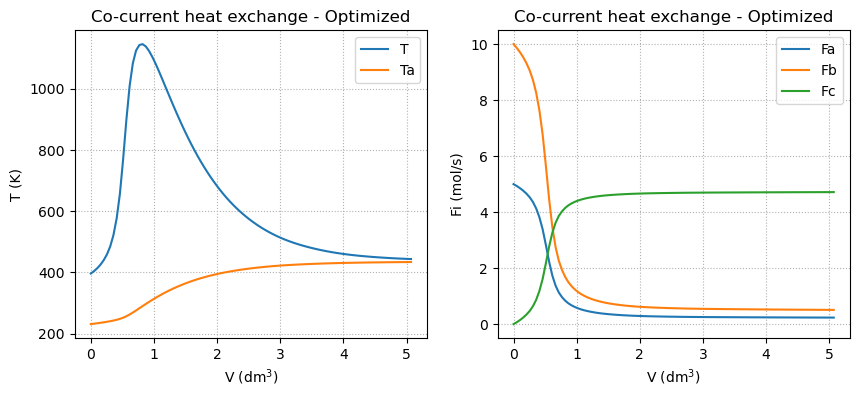

In [7]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 4), dpi = 100)


ax[0].set_ylabel("T (K)")
ax[0].set_xlabel("V (dm$^3$)")
ax[0].plot(sol_ode_constrained.t, sol_ode_constrained.y[4])
ax[0].plot(sol_ode_constrained.t, sol_ode_constrained.y[5])
ax[0].legend(['T', 'Ta'])
ax[0].grid(linestyle= ':')
ax[0].set_title('Co-current heat exchange - Optimized')

for yi in sol_ode_constrained.y[:-3]:
    ax[1].plot(sol_ode_constrained.t, yi)

ax[1].set_ylabel("Fi (mol/s)")
ax[1].set_xlabel("V (dm$^3$)")
ax[1].legend(['Fa', 'Fb', 'Fc'])
ax[1].grid(linestyle= ':')
ax[1].set_title('Co-current heat exchange - Optimized')